# 客户画像复赛 数据处理---09表（应收电费信息表）特征提取

In [1]:
!ls Data_Update/train/

01_arc_s_95598_wkst_train.tsv  06_cont_info.tsv		11_c_meter.tsv
02_s_comm_rec.tsv	       07_c_rca_cons.tsv	12_a_pay_flow.tsv
03_s_info_oversee.tsv	       08_a_rcved_flow.tsv	out
04_c_cons.tsv		       09_arc_a_rcvbl_flow.tsv	train_label.csv
05_c_cons_prc.tsv	       10_c_meter_read.tsv


## 1 导入必要的包和函数

In [1]:
%pdb 1
debug = 1
import pandas as pd
import numpy as np
import pickle
import re
import io 
import matplotlib.pyplot as plt
%matplotlib inline

# 加载预定义好的函数
# 预定义好的函数：
#    - load_data(file_name, header=0): 加载数据
#    - def show_attribute_detail( data=None, attribute_name=None): 显示数据某个属性的详情
%run data_util_func.py
# 选择过滤方案
PLAN_TYPE = 3

Automatic pdb calling has been turned ON


In [2]:
%%time
# 训练集敏感用户 和待预测用户列表
# train_data_labels_df
# test_data_labels_df
# 01表
# train_data01_merge_label_df
# test_data01_merge_label_df
# 代表工单数据
# train_data01_a_worker_per_user
# test_data01_a_worker_per_user
# 09表
# train_data09_merge_label_df
# test_data09_merge_label_df
%store -r train_data09_merge_label_df test_data09_merge_label_df
%store -r train_data01_a_worker_per_user test_data01_a_worker_per_user

CPU times: user 7.79 s, sys: 8.09 s, total: 15.9 s
Wall time: 29.5 s


In [3]:
%store -r train_data01_merge_label_df 
%store -r test_data01_merge_label_df

In [64]:
%store train_data01_a_worker_per_user 
%store test_data01_a_worker_per_user

Stored 'train_data01_a_worker_per_user' (DataFrame)
Stored 'test_data01_a_worker_per_user' (DataFrame)


In [4]:
%who_ls

['ACCEPT_CONTENT_TYPE_EXTRA_PARAM',
 'ACCEPT_CONTENT_TYPE_NONSENSITIVE_RATE',
 'Counter',
 'FeatureEncoder',
 'PLAN_TYPE',
 'RF_N_ESTIMATORS',
 'data_feature_encoder',
 'debug',
 'extend_train_data',
 'get_accept_content_type',
 'get_highest_sensitive_workerid',
 'get_metrics',
 'get_metrics2',
 'io',
 'load_data',
 'model_predict',
 'model_train',
 'np',
 'pd',
 'pickle',
 'plt',
 'print_function',
 're',
 'save_data',
 'seperate_data_to_classifier',
 'seperate_data_to_classifier_plan1',
 'seperate_data_to_classifier_plan2',
 'seperate_data_to_classifier_plan3',
 'seperate_data_to_classifier_plan4',
 'show_attribute_detail',
 'show_df_info',
 u'test_data_labels_df',
 u'train_data_labels_df',
 'train_test_split',
 'truncate_org_no']

In [36]:
del test_data_labels_df

##  2 加载数据 

### 2-1 应收电费信息表  09_ARC_A_RCVBL_FLOW

#### 2-1-1 训练集 

##### 2-1-1-1 加载数据  train/09_arc_a_rcvbl_flow.tsv

In [5]:
%%time
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
train_data09_df = load_data('Data_Update/train/09_arc_a_rcvbl_flow.tsv',
                           converters={'CONS_NO':unicode,'PAY_MODE':unicode,'ORG_NO':unicode}) 

print(train_data09_df.shape)
# 555,748 个用户
print len(train_data09_df['CONS_NO'].unique())

(6466654, 15)
555748
CPU times: user 21.7 s, sys: 3.02 s, total: 24.7 s
Wall time: 28.7 s


##### 2-1-1-2 数据摘要

In [8]:
# 6,466,654条记录
show_df_info(train_data09_df)

      CONS_NO  RCVBL_YM       ORG_NO  PAY_MODE  T_PQ  RCVBL_AMT  RCVED_AMT  \
0  6010969031    201502  33401010130   10101.0  1869    1768.07    1768.07   
1  6010811670    201502  33401010130   10101.0  2791    2640.29    2640.29   
2  6010777305    201502  33401010130   20311.0  1883    1058.25    1058.25   
3  6010777296    201502  33401010130   20311.0  4279    3585.80    3585.80   
4  6010777190    201502  33401010130   20311.0  2514    1561.93    1561.93   

   STATUS_CODE  RCVBL_PENALTY  RCVED_PENALTY  RISK_LEVEL_CODE  OWE_AMT  \
0            1           0.00           0.00              NaN  1768.07   
1            1           0.00           0.00              NaN  2640.29   
2            1           2.12           2.12              NaN  1058.25   
3            1           0.00           0.00              NaN  3585.80   
4            1           0.00           0.00              NaN  1561.93   

   CONS_SORT_CODE  ELEC_TYPE_CODE  CTL_MODE  
0             2.0           403.0       

In [192]:
train_data09_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN


##### 2-1-1-3 将数据连接上标签 

In [6]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 5,531,189 个 data09记录， 47,5723个用户
train_data09_merge_label_df = train_data09_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  935,465 个 data09记录,80,025个用户
train_data09_merge_label_df['TAG'] = train_data09_merge_label_df['TAG'].fillna(0)
train_data09_merge_label_df['TAG'] = train_data09_merge_label_df['TAG'].astype(int)
# 6,466,654条记录
print train_data09_merge_label_df.shape

(6466654, 17)
CPU times: user 4.13 s, sys: 2.19 s, total: 6.32 s
Wall time: 6.33 s


In [7]:
%store train_data09_merge_label_df

Stored 'train_data09_merge_label_df' (DataFrame)


In [74]:
# 6,466,654条记录
show_df_info(train_data09_merge_label_df)

      CONS_NO  RCVBL_YM       ORG_NO  PAY_MODE  T_PQ  RCVBL_AMT  RCVED_AMT  \
0  6010969031    201502  33401010130   10101.0  1869    1768.07    1768.07   
1  6010811670    201502  33401010130   10101.0  2791    2640.29    2640.29   
2  6010777305    201502  33401010130   20311.0  1883    1058.25    1058.25   
3  6010777296    201502  33401010130   20311.0  4279    3585.80    3585.80   
4  6010777190    201502  33401010130   20311.0  2514    1561.93    1561.93   

   STATUS_CODE  RCVBL_PENALTY  RCVED_PENALTY  RISK_LEVEL_CODE  OWE_AMT  \
0            1           0.00           0.00              NaN  1768.07   
1            1           0.00           0.00              NaN  2640.29   
2            1           2.12           2.12              NaN  1058.25   
3            1           0.00           0.00              NaN  3585.80   
4            1           0.00           0.00              NaN  1561.93   

   CONS_SORT_CODE  ELEC_TYPE_CODE  CTL_MODE CUST_NO  TAG  
0             2.0          

###### 输出 训练集中 所有用户和标签，共 555,748个用户

In [7]:
train_data09_cust_no_tag_df = \
    train_data09_merge_label_df[['CONS_NO','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data09_cust_no_tag_df,
    'train_data09_cust_no_tag_df.csv'
)
train_data09_cust_no_tag_df.shape

(555748, 2)

###### 从文件中恢复

In [4]:
# 全部转为字符串，否则在连接表的时候会出问题
train_data09_cust_no_tag_df = load_data('train_data09_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CONS_NO':unicode}
                                       )


##### 2-5-1-4 统计敏感和不敏感的情况

(2,)


0    5531189
1     935465
Name: TAG, dtype: int64

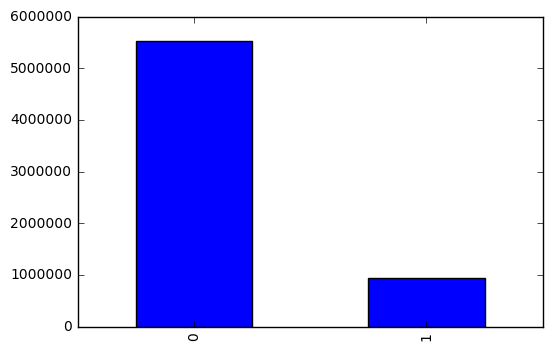

In [50]:
# 所有工单的统计
# 0    5,531,189
# 1     935,465
# 1/0   0.16912548
show_attribute_detail(train_data09_merge_label_df,'TAG')

(2,)


0    475723
1     80025
Name: TAG, dtype: int64

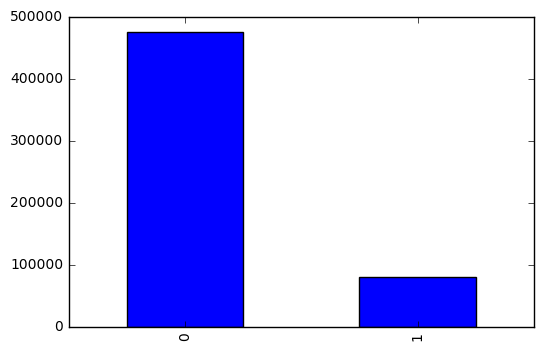

In [51]:
# 所有用户的统计
# 0    475,723
# 1     80,025   ---- 跟表1-data01 的敏感用户一样
# 1/0   0.1682176392
show_attribute_detail(train_data09_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),'TAG')

##### 和data01数据的用户列表比较

In [13]:
train_data01_data09_cust_no_tag_df = train_data01_cust_no_tag_df.merge(
    train_data09_cust_no_tag_df,
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658,374   ----  跟表1一样，即 表8和表9中所有用户都在表1中
# 在data01数据中，而不在data09数据中的用户数有：0
# 在data09数据中，而不在data01数据中的用户数有：102,626
print '合并所有用户有：%d'%train_data01_data09_cust_no_tag_df.shape[0]
print '在data09数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data09_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data09数据中的用户数有：%d'%sum(train_data01_data09_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data09数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data09数据中的用户数有：102626


(658374, 4)
(2,)
0    578349
1     80025
Name: TAG_x, dtype: int64
(102626, 4)
(1,)
0    102626
Name: TAG_x, dtype: int64
(555748, 4)
(2,)
0    475723
1     80025
Name: TAG_x, dtype: int64


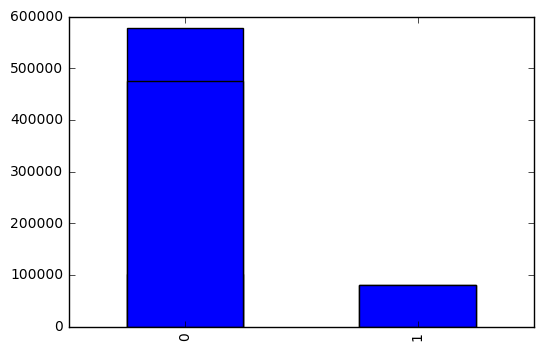

In [54]:
# 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.138367
print train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CUST_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CUST_NO'].notnull()],
    'TAG_x'
)

# 在data01数据中，而不在data09数据中的用户数有：102,626,其中不敏感有： 102,626，敏感有：0，1/0 比例为 
# 这是个关键信息，意味着连接不上 09表 的01表用户 都是非敏感的用户，可以拿去直接过滤测试数据
print train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].isnull()].shape
print show_attribute_detail(
    train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].isnull()],
    'TAG_x'
)
# 在data01数据中，也在data09数据中的用户数有：555,748,其中不敏感有： 475,723，敏感有：80,025，1/0 比例为 0.168217639
print train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].notnull()],
    'TAG_x'
)

##### 和data08数据的用户列表比较

In [58]:
train_data08_data09_cust_no_tag_df = train_data08_cust_no_tag_df.merge(
    train_data09_cust_no_tag_df,
    how='outer',
    on='CONS_NO',
)
# 08表和09表合并后，所有用户有：556,844   ----  表8和表9的用户不一致，即各有自己的用户
# 在data01数据中，而不在data09数据中的用户数有：1
# 在data09数据中，而不在data01数据中的用户数有：376223
print '合并所有用户有：%d'%train_data08_data09_cust_no_tag_df.shape[0]
print '在data08数据中，而不在data09数据中的用户数有：%d'%sum(train_data08_data09_cust_no_tag_df['TAG_x'].isnull())
print '在data09数据中，而不在data08数据中的用户数有：%d'%sum(train_data08_data09_cust_no_tag_df['TAG_y'].isnull())


合并所有用户有：556844
在data08数据中，而不在data09数据中的用户数有：274692
在data09数据中，而不在data08数据中的用户数有：1096


In [92]:
train_data08_data09_cust_no_tag_df.head()

,CONS_NO,TAG_x,TAG_y
0,6011035199,0.0,0.0
1,6120351106,0.0,0.0
2,6120116008,0.0,0.0
3,6118024684,0.0,0.0
4,6111023661,0.0,0.0


#### 2-5-2 测试集 

##### 2-5-1-1 加载数据  test/09_arc_a_rcvbl_flow_test.tsv

In [8]:
%%time
# 这个类型转换非常重要，因为发现在和 test_to_predict.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
test_data09_df = load_data('Data_Update/test/09_arc_a_rcvbl_flow_test.tsv',
                           converters={'CONS_NO':unicode,'PAY_MODE':unicode,'ORG_NO':unicode}) 
# 记录数 2479469
print(test_data09_df.shape)
# 201,702 个用户
len(test_data09_df['CONS_NO'].unique())

(2479469, 15)
CPU times: user 7.92 s, sys: 644 ms, total: 8.56 s
Wall time: 8.98 s


##### 2-5-1-2 数据摘要

In [49]:
# 2,479,469条记录
show_df_info(test_data09_df)

      CONS_NO  RCVBL_YM       ORG_NO  PAY_MODE  T_PQ  RCVBL_AMT  RCVED_AMT  \
0  8602008462    201509    334019001   20311.0   169      90.92      90.92   
1  8664221007    201509  33401900101   20311.0   290     156.02     156.02   
2  8664221012    201509  33401900101   20311.0   110      59.18      59.18   
3  8602060747    201509    334019001   20311.0    25      13.64      13.64   
4  8660041104    201509  33401900101   20311.0    44      23.67      23.67   

   STATUS_CODE  RCVBL_PENALTY  RCVED_PENALTY  RISK_LEVEL_CODE  OWE_AMT  \
0            1            0.0            0.0              NaN    90.92   
1            1            0.0            0.0              NaN   156.02   
2            1            0.0            0.0              NaN    59.18   
3            1            0.0            0.0              NaN    13.64   
4            1            0.0            0.0              NaN    23.67   

   CONS_SORT_CODE  ELEC_TYPE_CODE  CTL_MODE  
0             3.0           201.0       

In [192]:
test_data09_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN


###### 输出 测试集中 所有用户，共 201,702个用户

In [61]:
test_data09_cust_no_df = \
    test_data09_df['CONS_NO'].drop_duplicates()
save_data(
    test_data09_cust_no_df,
    'test_data09_cust_no_df.csv'
)
test_data09_cust_no_df.shape

(201702,)

###### 从文件中恢复

In [13]:
test_data09_cust_no_df = load_data('test_data09_cust_no_df.csv',
                                   encoding='utf8',
                                   converters={'CONS_NO':unicode}
                                   )
# 全部转为字符串，否则在连接表的时候会出问题


##### 2-5-2-2 将数据连接上待预测用户列表

In [9]:
%%time
test_data09_merge_label_df = test_data09_df.merge(
    test_data_labels_df,
    left_on='CONS_NO',
    right_on='CUST_NO',
    how='left'
)
print test_data09_merge_label_df.shape

(2479469, 16)
CPU times: user 2.06 s, sys: 384 ms, total: 2.44 s
Wall time: 2.88 s


In [10]:
%store test_data09_merge_label_df

Stored 'test_data09_merge_label_df' (DataFrame)


In [64]:
# 没在测试集中的数据有0,即全部都在测试集合
print sum(test_data09_merge_label_df['CUST_NO'].isnull())
# 总共用户数： 201,702
print len(test_data09_merge_label_df['CONS_NO'].unique()) 
# data01中用户 无 data09数据的 用户有 169,169 --- 根据训练集，连接不上09表的01表用户是否直接判为 非敏感
print 370871-len(test_data09_merge_label_df['CONS_NO'].unique())

0
201702
169169


#### 2-5-3 小结：
- 训练集有：6,466,654个 应收电费信息表 数据
       不敏感：5,531,189;敏感：935,465,不敏感/敏感:0.16912548
    - 将训练集客户编号提取并去重，发现训练集只有 555,748 个用户编号
       不敏感：475,723; 敏感：80,025（跟train_label.csv中敏感用户一样，意味着所有训练集中敏感用户都有表9）, 不敏感/敏感: 0.16912548

        - 合并所有用户有：658,374(跟表1一样，即表8和表9中所有用户都在表1中)
        - 在data09数据中，而不在data01数据中的用户数有：0
        - 在data01数据中，而不在data09数据中的用户数有：102,626
            
    - 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.138367
    - 在data01数据中，而不在data09数据中的用户数有：102,626,其中不敏感有： 102,626，敏感有：0，1/0 比例为 *（这是个关键信息，意味着连接不上 09表 的01表用户 都是非敏感的用户，可以拿去直接过滤测试数据）
    - 在data01数据中，也在data09数据中的用户数有：555,748,其中不敏感有： 475,723，敏感有：80,025，1/0 比例为 0.168217639


- 08表和09表合并后，所有用户有：556,844   ----  表8和表9的用户不一致，即各有自己的用户	
    - 在data08数据中，而不在data09数据中的用户数有：274692	
    - 在data09数据中，而不在data08数据中的用户数有：1096	


- 测试集有：  2,479,469 个工单数据
- 将测试集客户编号提取并去重，发现训练集只有 201,702 用户编号，全部都在test_to_predict.csv（370871个用户）中，
    - 而 test_to_predict.csv 中有 169,169 个不在该表中  --- **根据训练集，连接不上09表的01表用户是否直接判为 非敏感**



## 3 进行不同特征的探索

### 3-1 表1用户能否连接上09表

#### 3-1-1 训练集

In [5]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data09_cust_no_tag_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)
# 全部先设置 为 0
temp['IS_CONNECT_TO_09TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_09TABLE']=0


CPU times: user 1.14 s, sys: 160 ms, total: 1.3 s
Wall time: 1.3 s


In [8]:
# 修改
train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE'] = temp['IS_CONNECT_TO_09TABLE']

In [28]:
sum(temp['CONS_NO'].isnull()) == 102626,sum(train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==0) == 102626

NameError: name 'temp' is not defined

> <ipython-input-28-cd28c9f1fd8a>(1)<module>()
----> 1 sum(temp['CONS_NO'].isnull()) == 102626,sum(train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==0) == 102626

ipdb> q


#### 3-1-2 测试集

In [14]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data09_cust_no_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)

# 全部先设置 为 0
temp['IS_CONNECT_TO_09TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_09TABLE']=0


CPU times: user 620 ms, sys: 156 ms, total: 776 ms
Wall time: 777 ms


In [15]:
# 修改
test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE'] = temp['IS_CONNECT_TO_09TABLE']

In [18]:
sum(test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==0) ==169169

True

### 3-2 供电单位编号 ORG_NO     

#### 3-2-1 所有记录统计

##### 3-2-1-1 训练集

In [9]:
train_data09_merge_label_df_org_no_count_df = show_attribute_detail(
    train_data09_merge_label_df,
    'ORG_NO',
    split_by_tag=True, 
    tag_name='TAG', 
    show_pic=False
)
train_data09_merge_label_df_org_no_count_df.shape

(754, 5)


(754, 5)

##### 3-2-1-2 测试集

In [10]:
test_data09_merge_label_df_org_no_count_df = show_attribute_detail(
    test_data09_merge_label_df,
    'ORG_NO',
    show_pic=False
)

(621,)


##### 3-2-1-3 合并结果

In [16]:
temp = train_data09_merge_label_df_org_no_count_df.join(
    test_data09_merge_label_df_org_no_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['ORG_NO']
temp = temp.drop(labels = [u'ORG_NO'],axis=1)
print '所有data09 -供电单位编号 ORG_NO'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data09_merge_label_df_org_no_count.csv',
    index=True
)

所有data09 -供电单位编号 ORG_NO
              total    tag0  tag0/total    tag1  tag1/total  test_total
33406800136    49.0     0.0    0.000000    49.0    1.000000        66.0
3340901        20.0     7.0    0.350000    13.0    0.650000        13.0
33406600107   561.0   290.0    0.516934   271.0    0.483066       212.0
3340201       483.0   267.0    0.552795   216.0    0.447205        95.0
33401010911  6017.0  3357.0    0.557919  2660.0    0.442081         0.0
3340601        75.0    43.0    0.573333    32.0    0.426667        24.0
33406600130  4223.0  2436.0    0.576841  1787.0    0.423159      2165.0
3340501       884.0   512.0    0.579186   372.0    0.420814       487.0
33401010912  1911.0  1168.0    0.611198   743.0    0.388802         0.0
33410400160    34.0    21.0    0.617647    13.0    0.382353         5.0
33406600190  1030.0   637.0    0.618447   393.0    0.381553       543.0
33406600180  1615.0  1012.0    0.626625   603.0    0.373375       588.0
33401010530  3022.0  1904.0    0.630046 

#### 3-2-2 按用户统计 (因为 一个用户会有多个org_no，所以这里做截断处理，剩下7位，保证 用户org_no种类减少)

##### 3-2-2-1 训练集

In [6]:
%%time
# 尝试

truncate_len = 7
temp = train_data09_merge_label_df.groupby(
    by='CONS_NO',axis=0)['ORG_NO'].apply(
    lambda x :len(set([item[:truncate_len] for item in x 
                      ]))
)

# 7-仍然有两个 
print temp[temp>1].shape

(2,)
CPU times: user 29.7 s, sys: 404 ms, total: 30.1 s
Wall time: 29.8 s


In [8]:
%%time
truncate_len = 9
train_data09_merge_label_df['ORG_NO_%dbit'%truncate_len] = \
    train_data09_merge_label_df['ORG_NO'].str.slice(0,truncate_len)

CPU times: user 1.34 s, sys: 116 ms, total: 1.45 s
Wall time: 1.73 s


In [10]:
%%time
temp = train_data09_merge_label_df.groupby('CONS_NO')['ORG_NO_9bit'].apply(lambda x :len(set(x)))
temp[temp>1].head()

CPU times: user 29 s, sys: 256 ms, total: 29.3 s
Wall time: 29.2 s


##### 增加字段 ORG_NO_7/9bit

In [24]:
%%time
truncate_len = 9
train_data09_cons_no_truncate_org_no_series = train_data09_merge_label_df.groupby(
        by='CONS_NO',axis=0)['ORG_NO'].apply(lambda x : truncate_org_no(x, truncate_len=truncate_len))

CPU times: user 36.8 s, sys: 356 ms, total: 37.1 s
Wall time: 37.2 s


In [25]:
train_data09_merge_label_df['ORG_NO_%dbit'%truncate_len] = \
    train_data09_merge_label_df['CONS_NO'].map(train_data09_cons_no_truncate_org_no_series)

In [46]:
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_9bit
0,6010969031,201502,33401010130,010101,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN,NaN,0,334010101
1,6010811670,201502,33401010130,010101,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN,NaN,0,334010101
2,6010777305,201502,33401010130,020311,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN,NaN,0,334010101
3,6010777296,201502,33401010130,020311,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN,NaN,0,334010101
4,6010777190,201502,33401010130,020311,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN,NaN,0,334010101


In [27]:
# 输出是 555748 才是正确
train_data09_merge_label_df[['CONS_NO','ORG_NO_9bit','TAG']].drop_duplicates().shape

(555748, 3)

###### 统计

In [28]:
train_a_worker_per_user_org_no_count_df = show_attribute_detail(
    train_data09_merge_label_df[['ORG_NO_%dbit'%truncate_len,'CONS_NO','TAG']].drop_duplicates(),
    'ORG_NO_%dbit'%truncate_len,
    split_by_tag=True, 
    tag_name='TAG', 
    show_pic=False
)
train_a_worker_per_user_org_no_count_df

(105, 5)


,total,tag0,tag0/total,tag1,tag1/total
3340101,36,25,0.694444,11.0,0.305556
334010101,19189,15612,0.813591,3577.0,0.186409
334010102,20234,15505,0.766284,4729.0,0.233716
334010103,9703,7540,0.777079,2163.0,0.222921
334010104,34956,27809,0.795543,7147.0,0.204457
334010105,14832,11832,0.797735,3000.0,0.202265
334010106,18000,14507,0.805944,3493.0,0.194056
334010107,1507,1320,0.875912,187.0,0.124088
334010108,12000,10189,0.849083,1811.0,0.150917
334010109,692,392,0.566474,300.0,0.433526


##### 添加到 train_data01_a_worker_per_user中

In [29]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data09_merge_label_df[['ORG_NO_%dbit'%truncate_len,'CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['ORG_NO_%dbit'%truncate_len].isnull())

(658374, 57) 102626
CPU times: user 4.66 s, sys: 292 ms, total: 4.95 s
Wall time: 5.81 s


In [30]:
train_data01_a_worker_per_user['ORG_NO_%dbit'%truncate_len] = temp['ORG_NO_%dbit'%truncate_len]

##### 3-2-2-2 测试集

In [31]:
truncate_len = 9
temp = test_data09_merge_label_df.groupby(
    by='CONS_NO',axis=0)['ORG_NO'].apply(
    lambda x :len(set([unicode(item)[:truncate_len] for item in x 
                      ]))
)
# 7 - 无，全部用户都可以截断成功，且对应一个org_no
# 9 - 有 4个用户
print temp[temp>1].shape

(4,)


##### 增加字段 ORG_NO_7bit

In [88]:
%%time
truncate_len = 9
test_data09_merge_label_df['ORG_NO_%dbit'%truncate_len] = \
    test_data09_merge_label_df['ORG_NO'].apply(lambda x:unicode(x)[:truncate_len])

CPU times: user 1.72 s, sys: 100 ms, total: 1.82 s
Wall time: 1.82 s


In [37]:
%%time
truncate_len = 9
test_data09_cons_no_truncate_org_no_series = test_data09_merge_label_df.groupby(
        by='CONS_NO',axis=0)['ORG_NO'].apply(lambda x : truncate_org_no(x, truncate_len=truncate_len))


CPU times: user 13.1 s, sys: 72 ms, total: 13.1 s
Wall time: 13.3 s



In [39]:
test_data09_merge_label_df['ORG_NO_%dbit'%truncate_len] = \
    test_data09_merge_label_df['CONS_NO'].map(test_data09_cons_no_truncate_org_no_series)

In [34]:
test_data09_merge_label_df[['CONS_NO','ORG_NO_%dbit'%truncate_len]].drop_duplicates().shape

(201702, 2)

In [40]:
test_a_worker_per_user_org_no_count_df = show_attribute_detail(
    test_data09_merge_label_df[['ORG_NO_%dbit'%truncate_len,'CONS_NO']].drop_duplicates(),
    'ORG_NO_%dbit'%truncate_len,
    show_pic=False
)
test_a_worker_per_user_org_no_count_df.head()

(85,)


334019001    1744
3340201         5
334020102     816
334020106    6458
334020108    4077
Name: ORG_NO_9bit, dtype: int64

##### 添加到 test_data01_a_worker_per_user中

In [42]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data09_merge_label_df[['ORG_NO_%dbit'%truncate_len,'CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['ORG_NO_%dbit'%truncate_len].isnull())

(370871, 56) 169169
CPU times: user 1.82 s, sys: 4 ms, total: 1.82 s
Wall time: 2.1 s


In [43]:
test_data01_a_worker_per_user['ORG_NO_%dbit'%truncate_len] = temp['ORG_NO_%dbit'%truncate_len]

##### 结果统计

In [47]:
train_a_worker_per_user_org_no_count_df = show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'ORG_NO_9bit',
    True,
    'TAG',
    False
)

(105, 5)


In [48]:
test_a_worker_per_user_org_no_count_df = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'ORG_NO_9bit',
    show_pic=False
)

(85,)


##### 3-2-2-3 合并结果

In [50]:
temp = train_a_worker_per_user_org_no_count_df.join(
    test_a_worker_per_user_org_no_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['ORG_NO_9bit']
temp = temp.drop(labels = [u'ORG_NO_9bit'],axis=1)
print '所有连接上9表的用户 -供电单位编号 ORG_NO_9bit'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data09_merge_label_df_org_no_9bit_count.csv',
    index=True
)

所有连接上9表的用户 -供电单位编号 ORG_NO_9bit
           total    tag1  tag1/total   tag0  tag0/total  test_total
3340901       10     6.0    0.600000      4    0.400000         4.0
334010109    692   300.0    0.433526    392    0.566474         0.0
3340201       14     6.0    0.428571      8    0.571429         5.0
3340501       31    12.0    0.387097     19    0.612903        16.0
3340601        3     1.0    0.333333      2    0.666667         1.0
334104001      6     2.0    0.333333      4    0.666667         2.0
3340101       36    11.0    0.305556     25    0.694444         0.0
334103001      7     2.0    0.285714      5    0.714286         4.0
334094001      8     2.0    0.250000      6    0.750000         7.0
3340401        4     1.0    0.250000      3    0.750000         1.0
334105001      4     1.0    0.250000      3    0.750000         4.0
334010110  17335  4176.0    0.240900  13159    0.759100         0.0
334010102  20234  4729.0    0.233716  15505    0.766284         0.0
334010103   9703 

#### 3-2-3 小结
- 不同供电单位，敏感度差异挺大，可以考虑进一步研究

### 3-14 应收金额 RCVBL_AMT  ---- > 月平均电费

#### 3-13-1 训练集

In [82]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='6023211298'].sort_values(by='RCVBL_YM')

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,...,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_7bit,NUM_OF_MONTHS,RCVBL_AMT_SUM,AVERAGE_RCVBL_AMT
13650,6023211298,201501,334010101,10101.0,45,24.21,24.21,1,0.22,1.0,...,24.21,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
4710,6023211298,201502,334010101,10101.0,44,23.67,23.67,1,0.00,0.0,...,23.67,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
29279,6023211298,201503,334010101,10101.0,12,6.46,6.46,1,0.00,0.0,...,6.46,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
29497,6023211298,201503,334010101,10101.0,-262,-140.96,-140.96,1,0.00,0.0,...,-140.96,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
29498,6023211298,201503,334010101,10101.0,-101,-54.34,-54.34,1,0.00,0.0,...,-54.34,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
48499,6023211298,201504,334010101,10101.0,-36,-19.37,-19.37,1,0.00,0.0,...,-19.37,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
72900,6023211298,201504,334010101,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
93890,6023211298,201505,334010101,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
87031,6023211298,201506,334010101,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
114294,6023211298,201507,33401010141,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833


In [85]:
train_data08_df[train_data08_df['CONS_NO']=='6023211298']

,ORG_NO,CONS_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY
20025,334010101,6023211298,201502,20150210,24.21,1.0,24.21,201501,0.22
20026,334010101,6023211298,201502,20150210,23.67,0.0,23.67,201502,0.00
31230,334010101,6023211298,201503,20150313,-54.34,0.0,-54.34,201503,0.00
33187,334010101,6023211298,201503,20150313,6.46,0.0,6.46,201503,0.00
44644,334010101,6023211298,201503,20150324,-140.96,0.0,-140.96,201503,0.00
58002,334010101,6023211298,201504,20150423,-19.37,0.0,-19.37,201504,0.00


In [73]:
%%time
# 统计每个用户的 月份数
train_data09_cons_no_rcvbl_ym_count_series = \
    train_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_YM'].apply(lambda x: len(set(x)))

CPU times: user 26.2 s, sys: 1.64 s, total: 27.9 s
Wall time: 35.1 s


In [74]:
%%time
# 统计每个用户的所有 电费总额
train_data09_cons_no_rcvbl_amt_sum_series = train_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_AMT'].sum()

CPU times: user 2.14 s, sys: 144 ms, total: 2.29 s
Wall time: 2.45 s


In [75]:
%%time
# 添加字段 交了多少个月 的电费
train_data09_merge_label_df['NUM_OF_MONTHS'] = \
    train_data09_merge_label_df['CONS_NO'].map(train_data09_cons_no_rcvbl_ym_count_series)
# 添加字段 总电量
train_data09_merge_label_df['RCVBL_AMT_SUM'] = \
    train_data09_merge_label_df['CONS_NO'].map(train_data09_cons_no_rcvbl_amt_sum_series)

CPU times: user 5.26 s, sys: 44 ms, total: 5.3 s
Wall time: 5.34 s


In [78]:
# 添加字段 用户的平均电费 AVERAGE_OWE_AMT
train_data09_merge_label_df['AVERAGE_RCVBL_AMT'] = \
    train_data09_merge_label_df['RCVBL_AMT_SUM']/train_data09_merge_label_df['NUM_OF_MONTHS']
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,...,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_7bit,NUM_OF_MONTHS,RCVBL_AMT_SUM,AVERAGE_RCVBL_AMT
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,...,1768.07,2.0,403.0,NaN,NaN,0,3340101,8,21116.31,2639.53875
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,...,2640.29,2.0,403.0,NaN,NaN,0,3340101,8,16806.61,2100.82625
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,...,1058.25,3.0,202.0,NaN,NaN,0,3340101,8,9416.90,1177.11250
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,...,3585.80,3.0,201.0,NaN,NaN,0,3340101,8,27228.58,3403.57250
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,...,1561.93,3.0,202.0,NaN,NaN,0,3340101,8,15037.73,1879.71625


(2,)


0    71819
1     8544
Name: TAG, dtype: int64

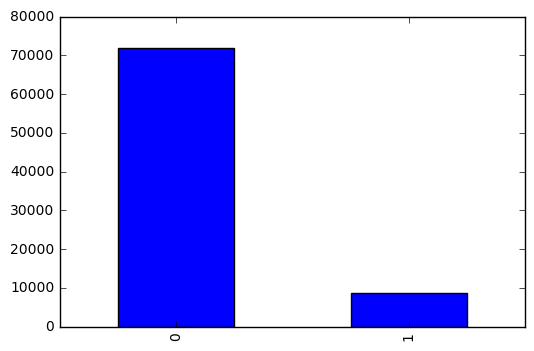

In [86]:
show_attribute_detail(
        train_data09_merge_label_df[train_data09_merge_label_df['AVERAGE_RCVBL_AMT']==0],
    'TAG'
    )

In [97]:
train_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_CONNECT_TO_08TABLE,NUM_OF_RCVBL_PENALTY,IS_CONNECT_TO_06TABLE,CONT_TYPE,IS_CONNECT_TO_07TABLE,CONS_STATUS,STATUS,RCA_FLAG,ORG_NO_7bit,AVERAGE_RCVBL_AMT
0,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,...,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2015101280031388,1000000527304861,3,1.0,3340901,2015/10/12 9:14:03,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1005636.0,NaN,...,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2015101280031424,1000000527305097,3,2.0,33401,2015/10/12 9:14:16,【查询电费】客户查询电费，已告知。,NaN,1007513.0,405.0,...,1,0.0,0,NaN,0,NaN,NaN,NaN,3340101.0,1652.304167
3,2015101280031680,1000000527300870,3,2.0,334020106,2015/10/12 9:11:37,【咨询总户号】通过地址（户名）查询户号信息。,NaN,1073266.0,202.0,...,1,0.0,0,NaN,0,NaN,NaN,NaN,3340201.0,51.961667
4,2015101280032506,1000000527305664,3,1.0,3340101,2015/10/12 9:14:48,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1433592.0,NaN,...,1,0.0,0,NaN,0,NaN,NaN,NaN,3340150.0,121.936250


##### 添加到 train_data01_a_worker_per_user中

In [94]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data09_merge_label_df[['AVERAGE_RCVBL_AMT','CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['AVERAGE_RCVBL_AMT'].isnull())

(658374, 48) 102626
CPU times: user 6.32 s, sys: 376 ms, total: 6.69 s
Wall time: 7.16 s


In [96]:
train_data01_a_worker_per_user['AVERAGE_RCVBL_AMT'] = temp['AVERAGE_RCVBL_AMT']

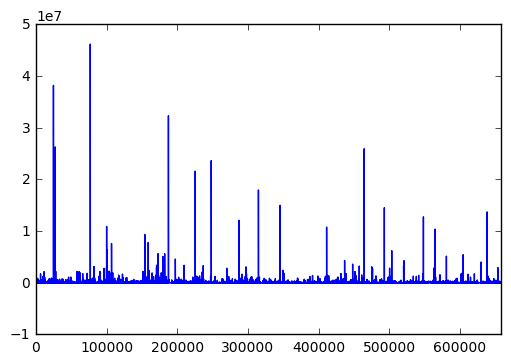

In [98]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['TAG']==1]['AVERAGE_RCVBL_AMT'].plot.line()

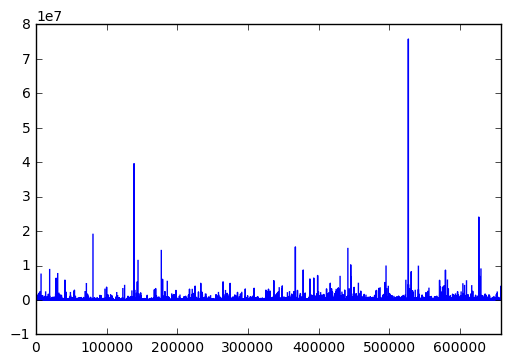

In [99]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['TAG']==0]['AVERAGE_RCVBL_AMT'].plot.line()

#### 3-13-1 测试集

In [71]:
test_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,ORG_NO_7bit
0,8602008462,201509,334019001,20311.0,169,90.92,90.92,1,0.0,0.0,NaN,90.92,3.0,201.0,NaN,8602008462,3340190
1,8664221007,201509,33401900101,20311.0,290,156.02,156.02,1,0.0,0.0,NaN,156.02,3.0,201.0,NaN,8664221007,3340190
2,8664221012,201509,33401900101,20311.0,110,59.18,59.18,1,0.0,0.0,NaN,59.18,3.0,201.0,NaN,8664221012,3340190
3,8602060747,201509,334019001,20311.0,25,13.64,13.64,1,0.0,0.0,NaN,13.64,3.0,202.0,NaN,8602060747,3340190
4,8660041104,201509,33401900101,20311.0,44,23.67,23.67,1,0.0,0.0,NaN,23.67,3.0,201.0,NaN,8660041104,3340190


In [100]:
%%time
# 统计每个用户的 月份数
test_data09_cons_no_rcvbl_ym_count_series = \
    test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_YM'].apply(lambda x: len(set(x)))

CPU times: user 10.4 s, sys: 580 ms, total: 10.9 s
Wall time: 16.5 s


In [101]:
%%time
# 统计每个用户的所有 电费总额
test_data09_cons_no_rcvbl_amt_sum_series = test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_AMT'].sum()

CPU times: user 708 ms, sys: 16 ms, total: 724 ms
Wall time: 949 ms


In [102]:
%%time
# 添加字段 交了多少个月 的电费
test_data09_merge_label_df['NUM_OF_MONTHS'] = \
    test_data09_merge_label_df['CONS_NO'].map(test_data09_cons_no_rcvbl_ym_count_series)
# 添加字段 总电量
test_data09_merge_label_df['RCVBL_AMT_SUM'] = \
    test_data09_merge_label_df['CONS_NO'].map(test_data09_cons_no_rcvbl_amt_sum_series)

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.07 s


In [103]:
# 添加字段 用户的平均电量 AVERAGE_OWE_AMT
test_data09_merge_label_df['AVERAGE_RCVBL_AMT'] = \
    test_data09_merge_label_df['RCVBL_AMT_SUM']/test_data09_merge_label_df['NUM_OF_MONTHS']
test_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,ORG_NO_7bit,NUM_OF_MONTHS,RCVBL_AMT_SUM,AVERAGE_RCVBL_AMT
0,8602008462,201509,334019001,20311.0,169,90.92,90.92,1,0.0,0.0,NaN,90.92,3.0,201.0,NaN,8602008462,3340190,6,451.39,75.231667
1,8664221007,201509,33401900101,20311.0,290,156.02,156.02,1,0.0,0.0,NaN,156.02,3.0,201.0,NaN,8664221007,3340190,7,704.77,100.681429
2,8664221012,201509,33401900101,20311.0,110,59.18,59.18,1,0.0,0.0,NaN,59.18,3.0,201.0,NaN,8664221012,3340190,7,463.21,66.172857
3,8602060747,201509,334019001,20311.0,25,13.64,13.64,1,0.0,0.0,NaN,13.64,3.0,202.0,NaN,8602060747,3340190,5,82.97,16.594000
4,8660041104,201509,33401900101,20311.0,44,23.67,23.67,1,0.0,0.0,NaN,23.67,3.0,201.0,NaN,8660041104,3340190,7,153.86,21.980000


##### 添加到 test_data01_a_worker_per_user中

In [104]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data09_merge_label_df[['AVERAGE_RCVBL_AMT','CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['AVERAGE_RCVBL_AMT'].isnull())

(370871, 48) 169169
CPU times: user 2.83 s, sys: 1.26 s, total: 4.09 s
Wall time: 11.6 s


In [105]:
test_data01_a_worker_per_user['AVERAGE_RCVBL_AMT'] = temp['AVERAGE_RCVBL_AMT']

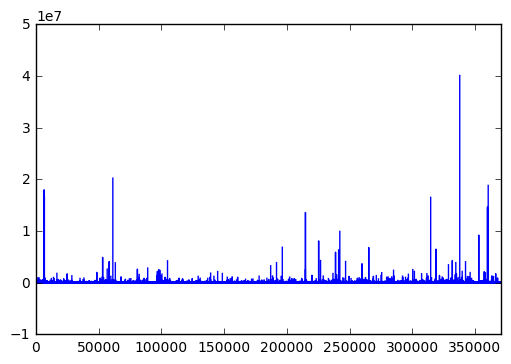

In [106]:
test_data01_a_worker_per_user['AVERAGE_RCVBL_AMT'].plot.line()

### 3-3 本次实收电费 THIS_RCVED_AMT     

#### 3-13-1 训练集

In [12]:
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN,NaN,0
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN,NaN,0
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN,NaN,0
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN,NaN,0
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN,NaN,0


In [130]:
%%time
train_data08_merge_label_this_reved_amt_sum_df = \
    train_data08_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['THIS_RCVED_AMT'].sum()

CPU times: user 2.84 s, sys: 748 ms, total: 3.58 s
Wall time: 4.58 s


In [130]:
%%time
train_data08_merge_label_this_reved_amt_sum_df = \
    train_data08_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['THIS_PENALTY'].sum()

CPU times: user 2.84 s, sys: 748 ms, total: 3.58 s
Wall time: 4.58 s


In [125]:
%%time
train_data09_merge_label_reved_amt_sum_df = \
    train_data09_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['RCVED_AMT'].sum()

CPU times: user 5.29 s, sys: 2.43 s, total: 7.72 s
Wall time: 10.6 s


In [125]:
%%time
train_data09_merge_label_reved_amt_sum_df = \
    train_data09_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['RCVED_PENALTY'].sum()

CPU times: user 5.29 s, sys: 2.43 s, total: 7.72 s
Wall time: 10.6 s


In [131]:
print train_data08_merge_label_this_reved_amt_sum_df.head()
print train_data09_merge_label_reved_amt_sum_df.head()

      CONS_NO  RCVBL_YM  THIS_RCVED_AMT
0  1081380222    201502          201.75
1  1100506263    201505           16.50
2  1100506385    201501           55.10
3  1100507494    201509           19.92
4  1100508075    201503           60.79
      CONS_NO  RCVBL_YM   RCVED_AMT
0  1000101001    201501  5301415.41
1  1000101001    201502  4372080.02
2  1000101001    201503  4829490.74
3  1000101001    201504  5375305.81
4  1000101001    201505  5294991.89


In [ ]:
train_data08_reved_amt_sum_df = pd.DataFrame(train_data08_merge_label_this_reved_amt_sum_df)
train_data09_reved_amt_sum_df = pd.DataFrame(train_data09_merge_label_reved_amt_sum_df)
print train_data08_reved_amt_sum_df.head()
print train_data09_reved_amt_sum_df.head()
# print train_data08_reved_amt_sum_df[u'1100565675']
save_data(
    train_data08_reved_amt_sum_df.merge(
        train_data09_merge_label_reved_amt_sum_df,
        how='outer',
        on=['CONS_NO','RCVBL_YM']),
    'temp.csv',
)

      CONS_NO  RCVBL_YM  THIS_RCVED_AMT
0  1081380222    201502          201.75
1  1100506263    201505           16.50
2  1100506385    201501           55.10
3  1100507494    201509           19.92
4  1100508075    201503           60.79
      CONS_NO  RCVBL_YM   RCVED_AMT
0  1000101001    201501  5301415.41
1  1000101001    201502  4372080.02
2  1000101001    201503  4829490.74
3  1000101001    201504  5375305.81
4  1000101001    201505  5294991.89


In [37]:
train_data09_merge_label_reved_amt_sum_df.head()

CONS_NO
1000101001    66434070.00
1000104008         143.10
1000108003      995971.48
1000108017     4749925.38
1000108020     5873519.25
Name: RCVED_AMT, dtype: float64

In [27]:
train_data08_merge_label_this_reved_amt_sum_df.head()

CONS_NO
1081380222    201.75
1100506263     16.50
1100506385     55.10
1100507494     19.92
1100508075     60.79
Name: THIS_RCVED_AMT, dtype: float64

In [39]:
train_data09_merge_label_reved_amt_sum_df.shape,train_data08_merge_label_this_reved_amt_sum_df.shape

((555748,), (282152,))

In [25]:
%%time
train_data08_merge_label_this_penalty_sum_df = \
    train_data08_merge_label_df.groupby(by='CONS_NO')['THIS_PENALTY'].sum()

CPU times: user 1.42 s, sys: 180 ms, total: 1.6 s
Wall time: 1.6 s


In [26]:
train_data08_merge_label_this_penalty_sum_df.head()

CONS_NO
1081380222    1.0
1100506263    0.0
1100506385    0.0
1100507494    0.0
1100508075    0.0
Name: THIS_PENALTY, dtype: float64

### 3-4 09表 应收违约金 RCVBL_PENALTY 的次数

#### 3-13-1 训练集

In [19]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='0002476706']

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_7bit
524654,0002476706,201501,33401010428,10101.0,0,0.00,0.00,1,0.00,0.00,NaN,0.00,2.0,405.0,NaN,NaN,0,3340101
536370,0002476706,201502,33401010428,10101.0,0,0.00,0.00,1,0.00,0.00,NaN,0.00,2.0,405.0,NaN,NaN,0,3340101
571758,0002476706,201503,33401010428,10101.0,0,0.00,0.00,1,0.00,0.00,NaN,0.00,2.0,405.0,NaN,NaN,0,3340101
632733,0002476706,201504,33401010428,10101.0,86,81.36,81.36,1,0.00,0.00,NaN,81.36,2.0,405.0,NaN,NaN,0,3340101
644199,0002476706,201505,33401010428,10101.0,88,82.92,82.92,1,0.00,0.00,NaN,82.92,2.0,405.0,NaN,NaN,0,3340101
679047,0002476706,201506,33401010428,10101.0,46,43.13,43.13,1,1.38,1.38,NaN,43.13,2.0,405.0,NaN,NaN,0,3340101
1149332,0002476706,201507,33401011025,10101.0,31,29.07,29.07,1,0.00,0.00,NaN,29.07,2.0,405.0,NaN,NaN,0,3340101


In [14]:
%%time
def count_num_of_rcvbl_amt(x):
    ym_set=set()
    for item in x.values:
        if item[0]>0:
            if not ym_set.__contains__(item[1]):
                ym_set.add(item[1])
    
#     print len(ym_set)


    return pd.Series(len(ym_set))

# 计算应收违约金 RCVBL_PENALTY 的次数
train_data09_rcvbl_amt_count_series = \
    train_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_PENALTY','RCVBL_YM'].apply(count_num_of_rcvbl_amt)

CPU times: user 1min 34s, sys: 808 ms, total: 1min 35s
Wall time: 1min 35s


In [36]:
train_data09_rcvbl_amt_count_dict = {i:j[0] for i,j in zip(train_data09_rcvbl_amt_count_series.index,train_data09_rcvbl_amt_count_series.values)}

In [37]:
train_data09_rcvbl_amt_count_dict['0002476706']

1

In [43]:
train_data01_a_worker_per_user['NUM_OF_RCVBL_PENALTY'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_rcvbl_amt_count_dict)

(13, 5)


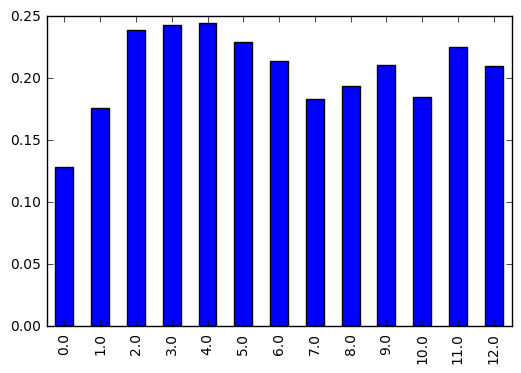

In [44]:
train_data01_a_worker_per_user_num_of_rcvbl_count_df = show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'NUM_OF_RCVBL_PENALTY',
    split_by_tag=True, tag_name='TAG'
).sort_values(by='tag1/total',ascending=False)

#### 3-13-1 测试集

In [45]:
%%time
def count_num_of_rcvbl_amt(x):
    ym_set=set()
    for item in x.values:
        if item[0]>0:
            if not ym_set.__contains__(item[1]):
                ym_set.add(item[1])
    
#     print len(ym_set)


    return pd.Series(len(ym_set))

# 计算应收违约金 RCVBL_PENALTY 的次数
test_data09_rcvbl_amt_count_series = \
    test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_PENALTY','RCVBL_YM'].apply(count_num_of_rcvbl_amt)
    
test_rcvbl_amt_count_series = test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_AMT'].apply(lambda x : sum([item>0 for item in x]))

CPU times: user 48.4 s, sys: 480 ms, total: 48.9 s
Wall time: 48.8 s
CPU times: user 48.4 s, sys: 484 ms, total: 48.9 s
Wall time: 48.8 s


In [46]:
test_data09_rcvbl_amt_count_dict = {i:j[0] for i,j in zip(test_data09_rcvbl_amt_count_series.index,test_data09_rcvbl_amt_count_series.values)}

##### 添加到 test_data01_a_worker_per_user中

In [51]:
test_data01_a_worker_per_user['NUM_OF_RCVBL_PENALTY'] = test_data01_a_worker_per_user['CUST_NO'].map(test_data09_rcvbl_amt_count_dict)

(13,)


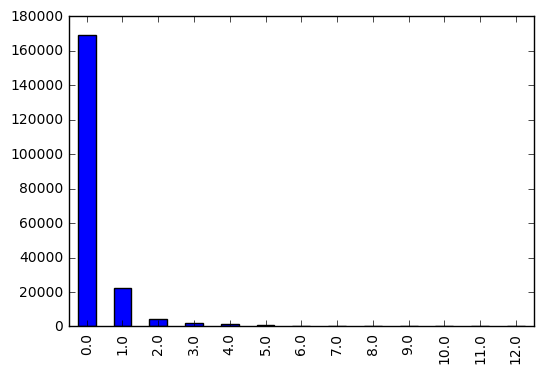

In [48]:
test_data01_a_worker_per_user_num_of_rcvbl_count_df = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'NUM_OF_RCVBL_PENALTY',
)

In [43]:
test_data01_a_worker_per_user['NUM_OF_RCVBL_PENALTY'] = temp['NUM_OF_RCVBL_PENALTY']

##### 3-12-1-3 合并结果

In [49]:
temp = train_data01_a_worker_per_user_num_of_rcvbl_count_df.join(
    test_data01_a_worker_per_user_num_of_rcvbl_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_RCVBL_PENALTY']
temp = temp.drop(labels = [u'NUM_OF_RCVBL_PENALTY'],axis=1)
print '代表工单 -应收违约金 RCVBL_PENALTY 的次数'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data01_a_worker_per_user_num_of_rcvbl_count_df.csv',
    index=True
)

代表工单 -应收违约金 RCVBL_PENALTY 的次数
       total   tag1  tag1/total    tag0  tag0/total  test_total
4.0     4775   1168    0.244607    3607    0.755393        1151
3.0     9806   2382    0.242913    7424    0.757087        2088
2.0    22187   5313    0.239465   16874    0.760535        4506
5.0     2429    558    0.229724    1871    0.770276         750
11.0     408     92    0.225490     316    0.774510         143
6.0     1381    296    0.214337    1085    0.785663         471
9.0      479    101    0.210856     378    0.789144         213
12.0     295     62    0.210169     233    0.789831         119
8.0      731    142    0.194254     589    0.805746         303
10.0     416     77    0.185096     339    0.814904         207
7.0      922    169    0.183297     753    0.816703         382
1.0    78203  13749    0.175812   64454    0.824188       22049
0.0   433716  55916    0.128923  377800    0.871077      169320


### 3-5 09表 平均电价的研究

In [87]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='3330137341'].sort_values('RCVBL_YM')

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_9bit
6047267,3330137341,201502,334080101,010101,9270,8076.78,8076.78,1,113.07,113.07,NaN,8076.78,1.0,405.0,NaN,3330137341,1,334080101
6071463,3330137341,201503,334080101,010101,11820,10388.51,10388.51,1,0.00,0.00,NaN,10388.51,1.0,405.0,NaN,3330137341,1,334080101
6079122,3330137341,201503,334080101,010101,8370,7089.60,7089.60,1,0.00,0.00,NaN,7089.60,1.0,405.0,NaN,3330137341,1,334080101
6110161,3330137341,201504,334080101,010101,5400,4622.89,4622.89,1,0.00,0.00,NaN,4622.89,1.0,405.0,NaN,3330137341,1,334080101
6121040,3330137341,201504,334080101,010101,13665,12474.25,12474.25,1,0.00,0.00,NaN,12474.25,1.0,405.0,NaN,3330137341,1,334080101
6111178,3330137341,201505,334080101,020331,7275,6596.34,6596.34,1,0.00,0.00,NaN,6596.34,1.0,405.0,NaN,3330137341,1,334080101
6120728,3330137341,201505,334080101,020331,12465,11336.49,11336.49,1,0.00,0.00,NaN,4101.59,1.0,405.0,NaN,3330137341,1,334080101
6124915,3330137341,201506,334080101,020331,19695,16636.51,16636.51,1,0.00,0.00,NaN,16636.51,1.0,405.0,NaN,3330137341,1,334080101
6145563,3330137341,201506,334080101,020331,25095,22190.95,22190.95,1,0.00,0.00,NaN,22190.95,1.0,405.0,NaN,3330137341,1,334080101
6167463,3330137341,201507,334080101,020331,22605,19144.02,19144.02,1,0.00,0.00,NaN,19144.02,1.0,405.0,NaN,3330137341,1,334080101


In [60]:
%%time
def count_money_per_degree(x):
    # 计算每度的电价
#     print x
    money = x.groupby('RCVBL_YM')['T_PQ'].sum().sort_index()
    electricity = x.groupby('RCVBL_YM')['RCVBL_AMT'].sum().sort_index()
    return (money/electricity).fillna(0)
    
temp = train_data09_merge_label_df.groupby('CONS_NO').apply(count_money_per_degree)

CPU times: user 13min 50s, sys: 7.85 s, total: 13min 58s
Wall time: 14min 42s


In [ ]:
temp[temp<0.558]

In [94]:
temp[(temp>=0.5) & (temp<=0.6)]

TypeError: index() takes at least 1 argument (0 given)

> <ipython-input-94-5ebefcf2ecba>(1)<module>()
----> 1 t = [(temp>=0.5) & (temp<=0.6)].index()

ipdb> q


In [93]:
type(t)

builtin_function_or_method

In [ ]:
%%time
def count_money_per_degree(x):
    # 计算每度的电价
#     print x
    money = x.groupby('RCVBL_YM')['T_PQ'].sum().sort_index()
    electricity = x.groupby('RCVBL_YM')['RCVBL_AMT'].sum().sort_index()
    return (money/electricity).fillna(0)
    
temp = test_data09_merge_label_df.groupby('CONS_NO').apply(count_money_per_degree)

### 3-6 09表 缴费方式的研究

In [3]:
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
0,6010969031,201502,33401010130,010101,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN,NaN,0
1,6010811670,201502,33401010130,010101,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN,NaN,0
2,6010777305,201502,33401010130,020311,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN,NaN,0
3,6010777296,201502,33401010130,020311,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN,NaN,0
4,6010777190,201502,33401010130,020311,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN,NaN,0


#### 3-6-1 统计缴费方式在所有记录下的分布情况

所有工单 - 缴费方式 PAY_MODE
(10, 5)


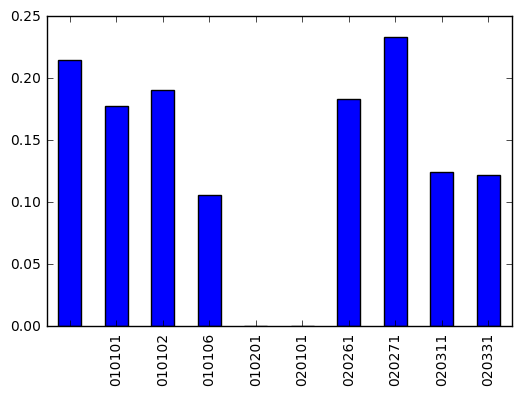

In [28]:
print '所有记录 - 缴费方式 PAY_MODE'
train_data09_pay_mode_count_df = show_attribute_detail(
    train_data09_merge_label_df,
    'PAY_MODE',
    True,
    'TAG'
)

所有工单 - 缴费方式 PAY_MODE
(8,)


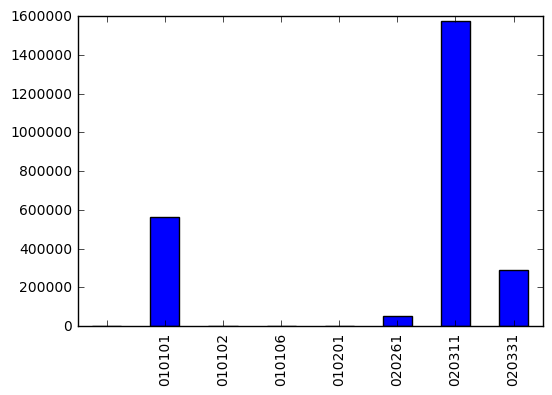

In [30]:
print '所有记录 - 缴费方式 PAY_MODE'
test_data09_pay_mode_count_df = show_attribute_detail(
    test_data09_merge_label_df,
    'PAY_MODE',
)

In [32]:
# 合并
temp = train_data09_pay_mode_count_df.join(
    test_data09_pay_mode_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['PAY_MODE']
temp = temp.drop(labels = [u'PAY_MODE'],axis=1)
print '所有记录 - 缴费方式 PAY_MODE'
print temp

代表工单 - 缴费方式 PAY_MODE
          total     tag0  tag0/total      tag1  tag1/total  test_total
020271    85040    65234    0.767098   19806.0    0.232902         0.0
             28       22    0.785714       6.0    0.214286         1.0
010102       63       51    0.809524      12.0    0.190476        18.0
020261   109152    89146    0.816714   20006.0    0.183286     50297.0
010101  2193015  1804004    0.822614  389011.0    0.177386    561957.0
020311  3540736  3099758    0.875456  440978.0    0.124544   1576987.0
020331   536279   470879    0.878049   65400.0    0.121951    289140.0
010106     2323     2077    0.894102     246.0    0.105898      1057.0
010201        5        5    1.000000       0.0    0.000000        12.0
020101       13       13    1.000000       0.0    0.000000         0.0


#### 3-6-2 用户使用过的支付方式的种类 NUM_OF_USED_PAY_MODE

In [12]:
# 比用户数多，说明有部分用户 是 有多种类型的 支付方式 
train_data09_merge_label_df[['CONS_NO','PAY_MODE','TAG']].drop_duplicates().shape

(610133, 3)

##### 训练集

In [10]:
%%time
train_data09_pay_mode_count_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x:len(set([item for item in x if len(x)!=0]))
)

CPU times: user 39.4 s, sys: 148 ms, total: 39.5 s
Wall time: 39.4 s


In [27]:
%%time
# 增加字段，使用过的 支付方式 样式
train_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_count_series)
print sum(train_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'].isnull())

102626
CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s


(3, 5)


,total,tag0,tag0/total,tag1,tag1/total
1.0,501868,429320,0.855444,72548,0.144556
2.0,53375,45955,0.860984,7420,0.139016
3.0,505,448,0.887129,57,0.112871


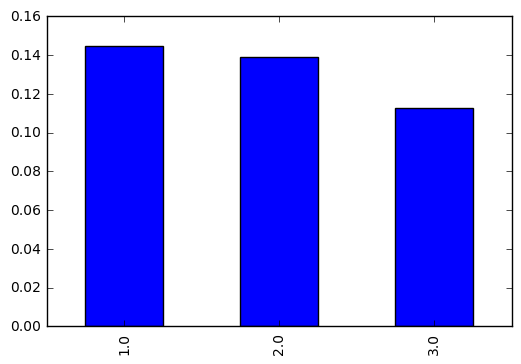

In [28]:
# 分布比较均匀，暂时发现不出价值
show_attribute_detail(
    train_data01_a_worker_per_user,
    'NUM_OF_USED_PAY_MODE',
    True,
    'TAG',
)


##### 测试集

In [33]:
%%time
test_data09_pay_mode_count_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x:len(set([item for item in x if len(x)!=0]))
)

CPU times: user 15.2 s, sys: 732 ms, total: 15.9 s
Wall time: 17.3 s


In [17]:
sum(train_data09_pay_mode_count_series<2)

501868

In [34]:
%%time
# 增加字段，使用过的 支付方式 样式
test_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_count_series)
print sum(test_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'].isnull())

169169
CPU times: user 1.25 s, sys: 52 ms, total: 1.3 s
Wall time: 1.44 s


(3,)


1.0    185047
2.0     16511
3.0       144
Name: NUM_OF_USED_PAY_MODE, dtype: int64

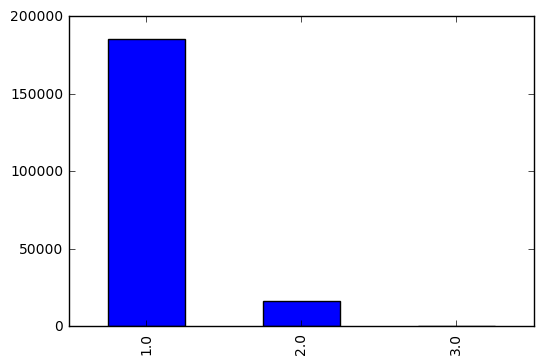

In [35]:
show_attribute_detail(
    test_data01_a_worker_per_user,
    'NUM_OF_USED_PAY_MODE',
)


#### 3-6-3 用户是否含有该 支付方式 010102等

In [49]:
# 支付方式列表 010101（）
# 0101-坐收    0101 01、0101 06、
train_data09_merge_label_df['PAY_MODE'].unique()

array([u'010101', u'020311', u'020271', u'020331', u'', u'010106',
       u'010102', u'020261', u'010201', u'020101'], dtype=object)

In [36]:
test_data09_merge_label_df[test_data09_merge_label_df['PAY_MODE']=='010201']

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO
331566,1701860262,201501,334030101,010201,243,104.98,104.98,1,0.0,0.0,NaN,104.98,3.0,202.0,NaN,1701860262
338714,1701860262,201502,334030101,010201,185,86.60,86.60,1,0.0,0.0,NaN,86.60,3.0,202.0,NaN,1701860262
340812,1701860262,201503,334030101,010201,135,61.28,61.28,1,0.0,0.0,NaN,61.28,3.0,202.0,NaN,1701860262
363434,1701860262,201504,334030101,010201,96,40.25,40.25,1,0.0,0.0,NaN,40.25,3.0,202.0,NaN,1701860262
364788,1701860262,201505,334030101,010201,76,31.13,31.13,1,0.0,0.0,NaN,31.13,3.0,202.0,NaN,1701860262
383436,1701860262,201506,334030101,010201,75,30.56,30.56,1,0.0,0.0,NaN,30.56,3.0,202.0,NaN,1701860262
387178,1701860262,201507,334030101,010201,119,51.63,51.63,1,0.0,0.0,NaN,51.63,3.0,202.0,NaN,1701860262
394362,1701860262,201508,334030101,010201,219,96.39,96.39,1,0.0,0.0,NaN,96.39,3.0,202.0,NaN,1701860262
405341,1701860262,201509,334030101,010201,238,105.78,105.78,1,0.0,0.0,NaN,105.78,3.0,202.0,NaN,1701860262
419114,1701860262,201510,334030101,010201,86,36.25,36.25,1,0.0,0.0,NaN,36.25,3.0,202.0,NaN,1701860262


(2,)


0    89146
1    20006
Name: TAG, dtype: int64

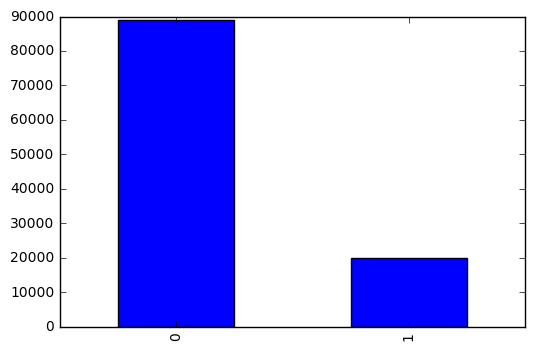

In [38]:
show_attribute_detail(
    train_data09_merge_label_df[train_data09_merge_label_df['PAY_MODE']=='020261'],
    'TAG'
)

#### 3-6-4 增加字段，是否包含支付方式 - 020311（代扣）

In [29]:
%%time
train_data09_pay_mode_contain020311_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020311'))>0)
)

CPU times: user 2min 37s, sys: 696 ms, total: 2min 37s
Wall time: 2min 38s


In [39]:
%%time
# 增加字段，是否包含支付方式 - 020311
train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_contain020311_series)
print sum(train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'].isnull())

102626
CPU times: user 1.72 s, sys: 32 ms, total: 1.75 s
Wall time: 1.95 s


In [15]:
%%time
test_data09_pay_mode_contain020311_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020311'))>0)
)

CPU times: user 45.6 s, sys: 196 ms, total: 45.8 s
Wall time: 45.8 s


In [40]:
%%time
# 增加字段，是否包含支付方式 - 020311
test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_contain020311_series)
print sum(test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'].isnull())

169169
CPU times: user 868 ms, sys: 292 ms, total: 1.16 s
Wall time: 3.25 s


(2, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,228439,188896,0.826899,39543,0.173101
1.0,327309,286827,0.876319,40482,0.123681


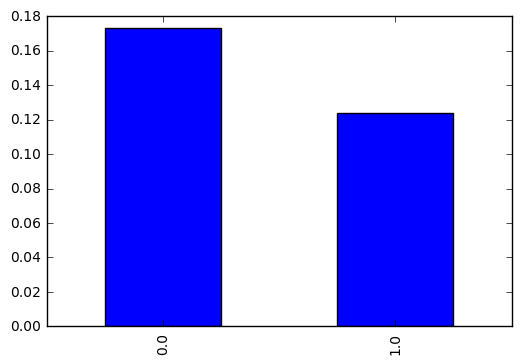

In [43]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_020311',
    True,
    'TAG'
)

#### 3-6-5 增加字段，是否包含支付方式 - 010101(坐收)

In [44]:
%%time
train_data09_pay_mode_contain010101_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('010101'))>0)
)

CPU times: user 2min 19s, sys: 716 ms, total: 2min 20s
Wall time: 2min 20s


In [45]:
%%time
# 增加字段，是否包含支付方式 - 010101
train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_contain010101_series)
print sum(train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'].isnull())

102626
CPU times: user 1.43 s, sys: 52 ms, total: 1.48 s
Wall time: 1.71 s


In [47]:
%%time
test_data09_pay_mode_contain010101_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('010101'))>0)
)

CPU times: user 53.7 s, sys: 296 ms, total: 54 s
Wall time: 55.4 s


In [48]:
%%time
# 增加字段，是否包含支付方式 - 010101
test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_contain010101_series)
print sum(test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'].isnull())

169169
CPU times: user 932 ms, sys: 4 ms, total: 936 ms
Wall time: 932 ms


(2, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,327204,287051,0.877285,40153,0.122715
1.0,228544,188672,0.825539,39872,0.174461


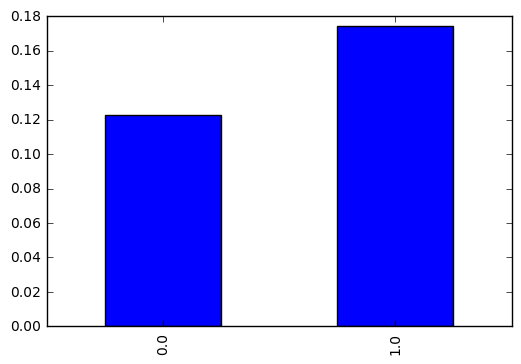

In [49]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_010101',
    True,
    'TAG'
)

#### 3-6-6 增加字段，是否包含支付方式 - 020261(委托特约)

In [50]:
%%time
train_data09_pay_mode_contain020261_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020261'))>0)
)

CPU times: user 2min 21s, sys: 652 ms, total: 2min 22s
Wall time: 2min 21s


In [51]:
%%time
# 增加字段，是否包含支付方式 - 020261
train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_contain020261_series)
print sum(train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'].isnull())

102626
CPU times: user 1.96 s, sys: 12 ms, total: 1.98 s
Wall time: 2.12 s


In [52]:
%%time
test_data09_pay_mode_contain020261_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020261'))>0)
)

CPU times: user 46.2 s, sys: 96 ms, total: 46.3 s
Wall time: 46.2 s


In [53]:
%%time
# 增加字段，是否包含支付方式 - 020261
test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_contain020261_series)
print sum(test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'].isnull())

169169
CPU times: user 944 ms, sys: 16 ms, total: 960 ms
Wall time: 1.01 s


(2, 5)
      total    tag0  tag0/total   tag1  tag1/total
0.0  549737  470790    0.856391  78947    0.143609
1.0    6011    4933    0.820662   1078    0.179338


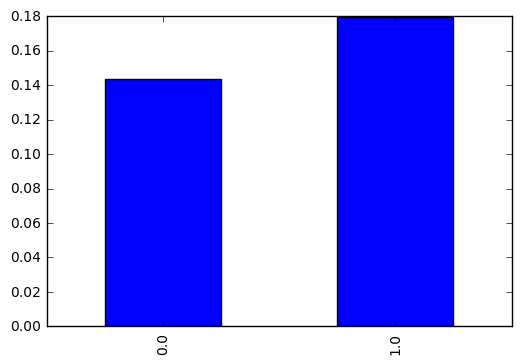

In [55]:
print show_attribute_detail(
    train_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_020261',
    True,
    'TAG'
)

(2,)
0.0    198837
1.0      2865
Name: IS_PAY_MODE_CONTAINS_020261, dtype: int64


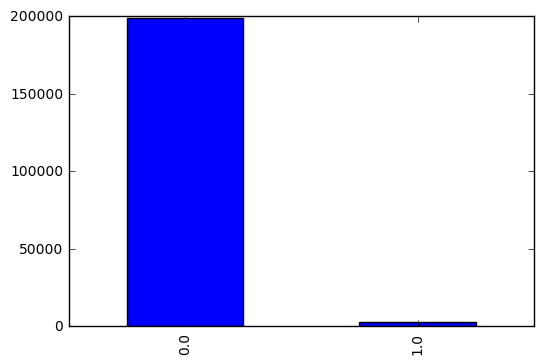

In [56]:
print show_attribute_detail(
    test_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_020261',
)

#### 3-6-7 最后一个月的支付方式

##### 3-6-7-1 训练集

In [29]:
%%time
# 获取最后一个月 的缴费方式
def get_last_month_pay_mode(x):
    last_month_pay_mode = x.sort_values(by='RCVBL_YM')['PAY_MODE'].iloc[-1]
    return last_month_pay_mode

train_data09_last_month_pay_mode_series = \
    train_data09_merge_label_df.groupby('CONS_NO').apply(get_last_month_pay_mode)

CPU times: user 4min 57s, sys: 3.52 s, total: 5min
Wall time: 5min 15s


##### 增加字段，最后一个月 的缴费方式

In [32]:
%%time
# 增加字段，最后一个月 的缴费方式
train_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_last_month_pay_mode_series)
print sum(train_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'].isnull())

102626
CPU times: user 1.92 s, sys: 16 ms, total: 1.94 s
Wall time: 2.07 s


#### 增加字段，最后一个月 的缴费方式前4位

In [7]:
train_data01_a_worker_per_user['LAST_MONTH_PAY_MODE_4bit'] = \
    train_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'].str.slice(0,4)

##### 3-6-7-2 测试集

In [30]:
%%time
# 获取最后一个月 的缴费方式
def get_last_month_pay_mode(x):
    last_month_pay_mode = x.sort_values(by='RCVBL_YM')['PAY_MODE'].iloc[-1]
    return last_month_pay_mode

test_data09_last_month_pay_mode_series = \
    test_data09_merge_label_df.groupby('CONS_NO').apply(get_last_month_pay_mode)

CPU times: user 1min 58s, sys: 1.68 s, total: 1min 59s
Wall time: 2min 5s


##### 增加字段，最后一个月 的缴费方式

In [34]:
%%time
# 增加字段，最后一个月 的缴费方式
test_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_last_month_pay_mode_series)
print sum(test_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'].isnull())

169169
CPU times: user 964 ms, sys: 0 ns, total: 964 ms
Wall time: 963 ms


#### 增加字段，最后一个月 的缴费方式前4位

In [8]:
test_data01_a_worker_per_user['LAST_MONTH_PAY_MODE_4bit'] = \
    test_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'].str.slice(0,4)

##### 3-6-7-3 统计结果

##### 最后一个月 的缴费方式

(9, 5)


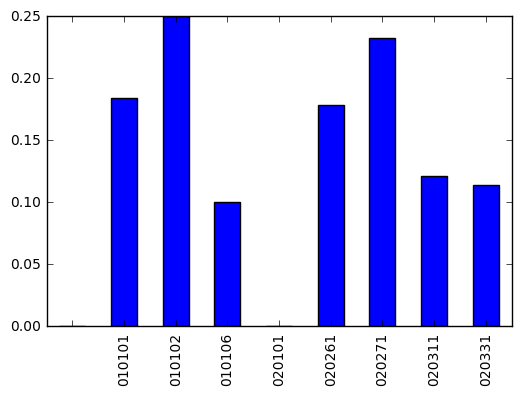

In [15]:
train_data09_last_month_pay_mode_count_df =  show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'LAST_MONTH_PAY_MODE',
    True,
    'TAG'
)

(7,)


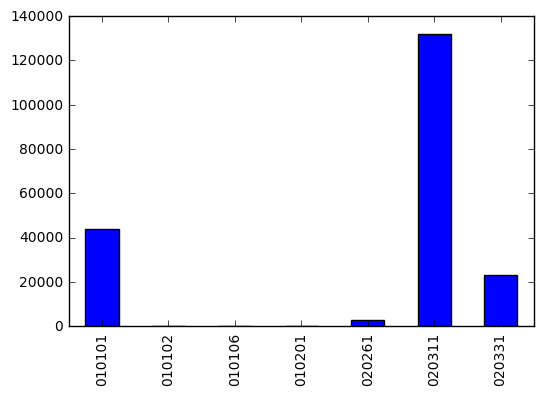

In [16]:
test_data09_last_month_pay_mode_count_df = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'LAST_MONTH_PAY_MODE',
)

In [17]:
# 合并
temp = train_data09_last_month_pay_mode_count_df.join(
    test_data09_last_month_pay_mode_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['LAST_MONTH_PAY_MODE']
temp = temp.drop(labels = [u'LAST_MONTH_PAY_MODE'],axis=1)
print '所有用户 - 最后一个缴费方式 PAY_MODE'
print temp

所有用户 - 最后一个缴费方式 PAY_MODE
           total     tag1  tag1/total      tag0  tag0/total  test_total
010102       4.0      1.0    0.250000       3.0    0.750000         1.0
020271    4857.0   1129.0    0.232448    3728.0    0.767552         0.0
010101  191966.0  35323.0    0.184007  156643.0    0.815993     43949.0
020261    5471.0    978.0    0.178761    4493.0    0.821239      2627.0
020311  312338.0  37922.0    0.121413  274416.0    0.878587    131989.0
020331   40960.0   4657.0    0.113696   36303.0    0.886304     23066.0
010106     150.0     15.0    0.100000     135.0    0.900000        69.0
             1.0      0.0    0.000000       1.0    1.000000         0.0
010201       0.0      0.0    0.000000       0.0    0.000000         1.0
020101       1.0      0.0    0.000000       1.0    1.000000         0.0


##### 最后一个月 的缴费方式前4位

(5, 5)


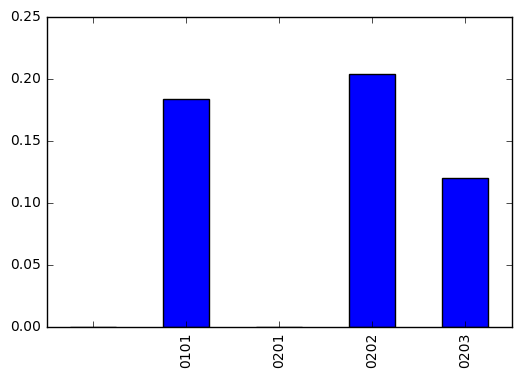

In [12]:
train_data09_last_month_pay_mode_count_df =  show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'LAST_MONTH_PAY_MODE_4bit',
    True,
    'TAG'
)

(4,)


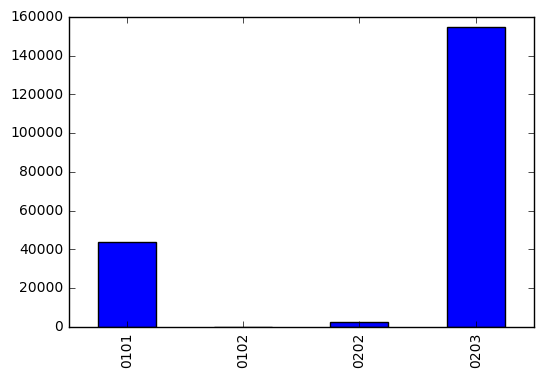

In [13]:
test_data09_last_month_pay_mode_count_df = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'LAST_MONTH_PAY_MODE_4bit',
)

In [14]:
# 合并
temp = train_data09_last_month_pay_mode_count_df.join(
    test_data09_last_month_pay_mode_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['LAST_MONTH_PAY_MODE_4bit']
temp = temp.drop(labels = [u'LAST_MONTH_PAY_MODE_4bit'],axis=1)
print '所有用户 - 最后一个缴费方式前4位 PAY_MODE'
print temp

所有用户 - 最后一个缴费方式前4位 PAY_MODE
         total     tag1  tag1/total      tag0  tag0/total  test_total
0202   10328.0   2107.0    0.204009    8221.0    0.795991      2627.0
0101  192120.0  35339.0    0.183942  156781.0    0.816058     44019.0
0203  353298.0  42579.0    0.120519  310719.0    0.879481    155055.0
           1.0      0.0    0.000000       1.0    1.000000         0.0
0102       0.0      0.0    0.000000       0.0    0.000000         1.0
0201       1.0      0.0    0.000000       1.0    1.000000         0.0


#### 3-6-8 支付方式的转变

In [54]:
%%time
# 缴费方式的变化线索
def get_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values)
    return pay_mode_change_clue
    
train_data09_pay_mode_change_clue_series = \
    train_data09_merge_label_df.groupby('CONS_NO').apply(get_pay_mode_change_clue)

CPU times: user 11min 10s, sys: 4.64 s, total: 11min 15s
Wall time: 11min 32s


In [55]:
%%time
# 缴费方式的变化线索
def get_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values)
    return pay_mode_change_clue
    
test_data09_pay_mode_change_clue_series = \
    test_data09_merge_label_df.groupby('CONS_NO').apply(get_pay_mode_change_clue)

CPU times: user 4min 31s, sys: 1.34 s, total: 4min 32s
Wall time: 4min 39s


In [56]:
train_data09_pay_mode_change_clue_series

CONS_NO
0002471802           020311
0002471815           020311
0002476706           010101
0002506278           020331
0002507444           020311
0002557351           020331
0002576549    010101-020331
0002581705    010101-020311
0002581851           010101
0002581877           020311
0002581949           010101
0002582056           020311
0002582098           010101
0002582160           010101
0002582199           010101
0002582232           010101
0002582258           020311
0002582261    020311-010101
0002582320           020311
0002582564           010101
0002583134           010101
0002583235           010101
0002583264           020311
0002583277           010101
0002583323           010101
0002583394           020311
0002583482    010101-020311
0002583538           010101
0002583541    010101-020311
0002583554           010101
                  ...      
9920038175           010101
9920038177    010101-020311
9920038179           010101
9920038180           010101
9920038210  

In [57]:
%%time
# 增加字段，缴费方式的转变路径
train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_change_clue_series)
print sum(train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'].isnull())

102626
CPU times: user 1.97 s, sys: 132 ms, total: 2.1 s
Wall time: 3.42 s


In [58]:
%%time
# 增加字段，缴费方式的转变路径
test_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_change_clue_series)
print sum(test_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'].isnull())

169169
CPU times: user 1.02 s, sys: 60 ms, total: 1.08 s
Wall time: 1.52 s


##### 统计结果

(57, 5)


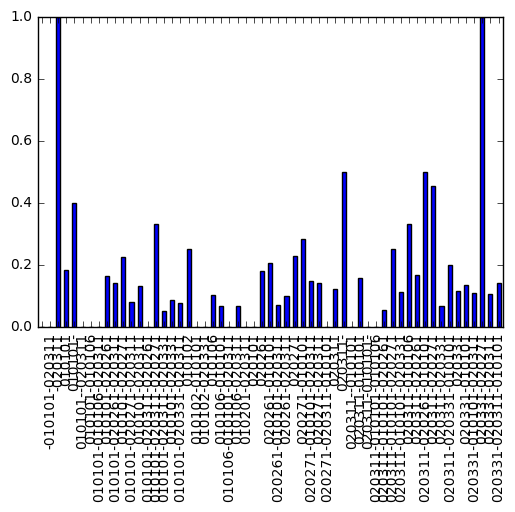

In [59]:
train_data09_pay_mode_change_clue_count_df =  show_attribute_detail(
    train_data01_a_worker_per_user,
    'PAY_MODE_CHANGE_CLUE',
    True,
    'TAG'
)

(35,)


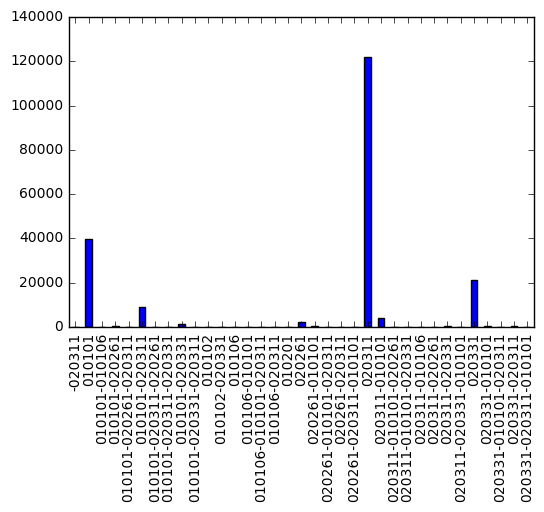

In [60]:
test_data09_pay_mode_change_clue_count_df = show_attribute_detail(
    test_data01_a_worker_per_user,
    'PAY_MODE_CHANGE_CLUE',
)

In [62]:
# 合并
temp = train_data09_pay_mode_change_clue_count_df.join(
    test_data09_pay_mode_change_clue_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['PAY_MODE_CHANGE_CLUE']
temp = temp.drop(labels = [u'PAY_MODE_CHANGE_CLUE'],axis=1)
print '所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data09_pay_mode_change_clue_count_df.csv',
    index=True
)

所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE
                         total      tag0  tag0/total     tag1  tag1/total  \
-020311                    1.0       0.0    0.000000      1.0    1.000000   
020331-020271              1.0       0.0    0.000000      1.0    1.000000   
020311-                    2.0       1.0    0.500000      1.0    0.500000   
020311-020261-010101       4.0       2.0    0.500000      2.0    0.500000   
020311-020271             11.0       6.0    0.545455      5.0    0.454545   
010101-                    5.0       3.0    0.600000      2.0    0.400000   
010101-020311-020271       3.0       2.0    0.666667      1.0    0.333333   
020311-010106              3.0       2.0    0.666667      1.0    0.333333   
020271-010101            344.0     246.0    0.715116     98.0    0.284884   
020311-010101-020271       4.0       3.0    0.750000      1.0    0.250000   
010102                     4.0       3.0    0.750000      1.0    0.250000   
020271                  4304.0    3322

#### 支付方式（只取前4位）的转变

In [83]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['CUST_NO']=='1040110018']

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE,MAX_NUM_MONTH_SEARCH_ACTION,NUM_OF_USED_PAY_MODE,IS_PAY_MODE_CONTAINS_020311,IS_PAY_MODE_CONTAINS_010101,IS_PAY_MODE_CONTAINS_020261,LAST_MONTH_PAY_MODE,PAY_MODE_CHANGE_CLUE
1242,2015100579171054,1000000521504770,1,2.0,3340550,2015/10/5 16:28:38,【一户无电】客户报修非居民一户停电，经指导客户检查，怀疑为供电资产表计故障，请现场查处。,NaN,1663649.0,100.0,...,2.0,0,NaN,0.0,2.0,0.0,1.0,1.0,010101,020261-010101


In [80]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='1040110018'].sort_values(by='RCVBL_YM')

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
4873219,1040110018,201501,33405500104,020261,68130,119463.81,119463.81,1,0.0,0.0,NaN,119463.81,1.0,100.0,NaN,NaN,0
4893440,1040110018,201501,33405500104,020261,188760,155473.62,155473.62,1,0.0,0.0,NaN,155473.62,1.0,100.0,NaN,NaN,0
4899361,1040110018,201502,33405500104,020261,195090,160847.61,160847.61,1,0.0,0.0,NaN,160847.61,1.0,100.0,NaN,NaN,0
4919622,1040110018,201502,33405500104,020261,29610,86705.42,86705.42,1,0.0,0.0,NaN,86705.42,1.0,100.0,NaN,NaN,0
4918066,1040110018,201503,33405500104,020261,69600,120061.37,120061.37,1,0.0,0.0,NaN,120061.37,1.0,100.0,NaN,NaN,0
4918090,1040110018,201503,33405500104,020261,101670,81885.45,81885.45,1,0.0,0.0,NaN,81885.45,1.0,100.0,NaN,NaN,0
4942934,1040110018,201504,33405500104,020261,185310,150941.49,150941.49,1,0.0,0.0,NaN,150941.49,1.0,100.0,NaN,NaN,0
4929016,1040110018,201504,33405500104,020261,66600,114788.35,114788.35,1,0.0,0.0,NaN,114788.35,1.0,100.0,NaN,NaN,0
4932230,1040110018,201505,33405500104,020261,49770,101603.44,101603.44,1,0.0,0.0,NaN,101603.44,1.0,100.0,NaN,NaN,0
4929088,1040110018,201505,33405500104,020261,145920,111806.65,111806.65,1,0.0,0.0,NaN,111806.65,1.0,100.0,NaN,NaN,0


In [98]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='3260016270'].sort_values(by='RCVBL_YM')

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
2585461,3260016270,201501,334024001,020311,734,828.72,828.72,1,0.0,0.0,NaN,828.72,1.0,403.0,NaN,NaN,0
2585463,3260016270,201501,334024001,020311,4825,4715.81,4715.81,1,0.0,0.0,NaN,4715.81,1.0,403.0,NaN,NaN,0
2599619,3260016270,201501,334024001,020311,2404,2344.94,2344.94,1,0.0,0.0,NaN,2344.94,1.0,403.0,NaN,NaN,0
2626849,3260016270,201502,334024001,020311,6279,6134.40,6134.40,1,0.0,0.0,NaN,6134.40,1.0,403.0,NaN,NaN,0
2622064,3260016270,201502,334024001,020311,2714,2654.49,2654.49,1,0.0,0.0,NaN,2654.49,1.0,403.0,NaN,NaN,0
2628428,3260016270,201502,334024001,020311,945,968.85,968.85,1,0.0,0.0,NaN,968.85,1.0,403.0,NaN,NaN,0
2623820,3260016270,201503,334024001,020331,267,251.46,251.46,1,0.0,0.0,NaN,251.46,1.0,403.0,NaN,NaN,0
2623819,3260016270,201503,334024001,020311,2227,2172.63,2172.63,1,0.0,0.0,NaN,2172.63,1.0,403.0,NaN,NaN,0
2622211,3260016270,201503,334024001,010101,560,798.39,798.39,1,0.0,0.0,NaN,798.39,1.0,403.0,NaN,NaN,0
2611095,3260016270,201503,334024001,020311,1930,1868.29,1868.29,1,0.0,0.0,NaN,1868.29,1.0,403.0,NaN,NaN,0


In [46]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='3002096443'].sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values

array([u'020311', u'010101', u'020331'], dtype=object)

(9, 5)


,total,tag1,tag1/total,tag0,tag0/total
,1,0.0,0.000000,1,1.000000
010101,191966,35323.0,0.184007,156643,0.815993
010102,4,1.0,0.250000,3,0.750000
010106,150,15.0,0.100000,135,0.900000
020101,1,0.0,0.000000,1,1.000000
020261,5471,978.0,0.178761,4493,0.821239
020271,4857,1129.0,0.232448,3728,0.767552
020311,312338,37922.0,0.121413,274416,0.878587
020331,40960,4657.0,0.113696,36303,0.886304


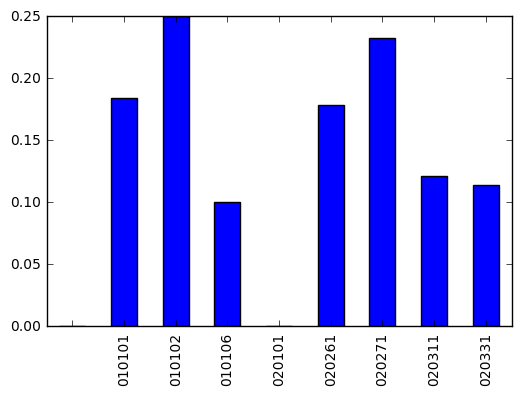

In [90]:
show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'LAST_MONTH_PAY_MODE',
    True,
    'TAG'
)

In [94]:
%%time
temp = \
    train_data09_merge_label_df.groupby(['CONS_NO','RCVBL_YM'],as_index=False)['PAY_MODE'].apply(lambda x:len(set(x)))

CPU times: user 5min 37s, sys: 3.34 s, total: 5min 40s
Wall time: 5min 39s


In [97]:
temp[temp>2]

CONS_NO     RCVBL_YM
3260016270  201503      3
3516008756  201502      3
3516026593  201502      3
Name: PAY_MODE, dtype: int64

In [54]:
%%time
# 缴费方式的变化线索
def get_short_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(
        [item[:4] for item in x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values]
    )
    return pay_mode_change_clue
    
train_data09_short_pay_mode_change_clue_series = \
    train_data09_merge_label_df.groupby('CONS_NO').apply(get_short_pay_mode_change_clue)

CPU times: user 11min 10s, sys: 4.64 s, total: 11min 15s
Wall time: 11min 32s


In [68]:
%%time
# 缴费方式的变化线索
def get_short_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(
        [item[:4] for item in x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values]
    )
    return pay_mode_change_clue
    
test_data09_short_pay_mode_change_clue_series = \
    test_data09_merge_label_df.groupby('CONS_NO').apply(get_short_pay_mode_change_clue)

CPU times: user 4min 5s, sys: 796 ms, total: 4min 5s
Wall time: 4min 8s


In [72]:
test_data09_short_pay_mode_change_clue_series[test_data09_short_pay_mode_change_clue_series=='0203-0203-0101']

CONS_NO
3315570506    0203-0203-0101
3318096796    0203-0203-0101
3318135859    0203-0203-0101
3318137151    0203-0203-0101
3330047031    0203-0203-0101
3330090717    0203-0203-0101
3330128826    0203-0203-0101
4510300057    0203-0203-0101
4511400405    0203-0203-0101
4515049897    0203-0203-0101
4520037095    0203-0203-0101
dtype: object

In [57]:
%%time
# 增加字段，缴费方式的转变路径
train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_change_clue_series)
print sum(train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'].isnull())

102626
CPU times: user 1.97 s, sys: 132 ms, total: 2.1 s
Wall time: 3.42 s


In [70]:
%%time
# 增加字段，缴费方式的转变路径
test_data01_a_worker_per_user['ShORT_PAY_MODE_CHANGE_CLUE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_short_pay_mode_change_clue_series)
print sum(test_data01_a_worker_per_user['ShORT_PAY_MODE_CHANGE_CLUE'].isnull())

169169
CPU times: user 1.01 s, sys: 36 ms, total: 1.04 s
Wall time: 1.39 s


##### 统计结果

(57, 5)


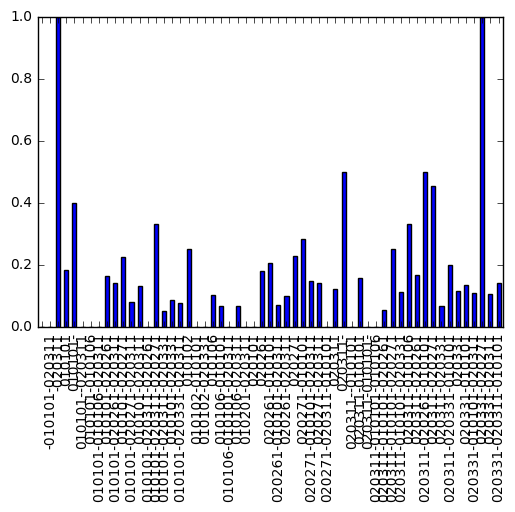

In [59]:
train_data09_pay_mode_change_clue_count_df =  show_attribute_detail(
    train_data01_a_worker_per_user,
    'PAY_MODE_CHANGE_CLUE',
    True,
    'TAG'
)

(22,)


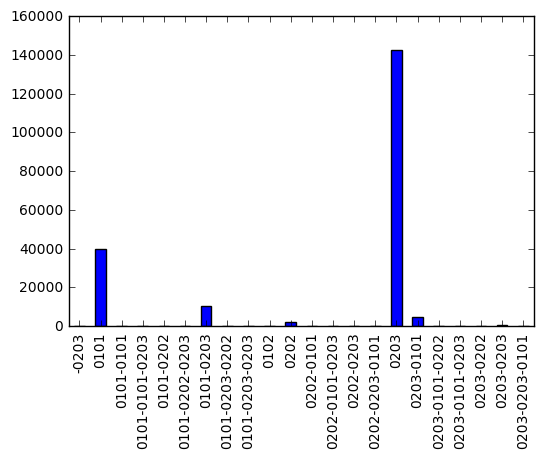

In [71]:
test_data09_pay_mode_change_clue_count_df = show_attribute_detail(
    test_data01_a_worker_per_user,
    'ShORT_PAY_MODE_CHANGE_CLUE',
)

In [62]:
# 合并
temp = train_data09_pay_mode_change_clue_count_df.join(
    test_data09_pay_mode_change_clue_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['PAY_MODE_CHANGE_CLUE']
temp = temp.drop(labels = [u'PAY_MODE_CHANGE_CLUE'],axis=1)
print '所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data09_pay_mode_change_clue_count_df.csv',
    index=True
)

所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE
                         total      tag0  tag0/total     tag1  tag1/total  \
-020311                    1.0       0.0    0.000000      1.0    1.000000   
020331-020271              1.0       0.0    0.000000      1.0    1.000000   
020311-                    2.0       1.0    0.500000      1.0    0.500000   
020311-020261-010101       4.0       2.0    0.500000      2.0    0.500000   
020311-020271             11.0       6.0    0.545455      5.0    0.454545   
010101-                    5.0       3.0    0.600000      2.0    0.400000   
010101-020311-020271       3.0       2.0    0.666667      1.0    0.333333   
020311-010106              3.0       2.0    0.666667      1.0    0.333333   
020271-010101            344.0     246.0    0.715116     98.0    0.284884   
020311-010101-020271       4.0       3.0    0.750000      1.0    0.250000   
010102                     4.0       3.0    0.750000      1.0    0.250000   
020271                  4304.0    3322